In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline

In [3]:
climate_disaster = 'Data/Climate_Disaster_Data/24_Climate-related_Disasters_Frequency.csv'
climate_disaster_df = pd.read_csv(climate_disaster)
climate_disaster_df.drop(columns=['Country','ISO2','Source','CTS Code', 'CTS Full Descriptor','Unit','CTS Name','Climate Influence'], inplace=True)
climate_disaster_df['Indicator'] = climate_disaster_df['Indicator'].str.split(',|:',expand=True)[2].str.strip()
climate_disaster_df = climate_disaster_df[climate_disaster_df['Indicator'] != 'TOTAL']
climate_disaster_df = pd.melt(climate_disaster_df, id_vars=['ISO3','Indicator'],var_name='Year', value_name='Frequency')

It's better to replace null with `0` by EAD defination of climate disaster:
- Killed ten (10) or more people 
- Affected hundred (100) or more people 
- Led to declaration of a state of emergency
- Led to call for international assistance  

<AxesSubplot: xlabel='Year'>

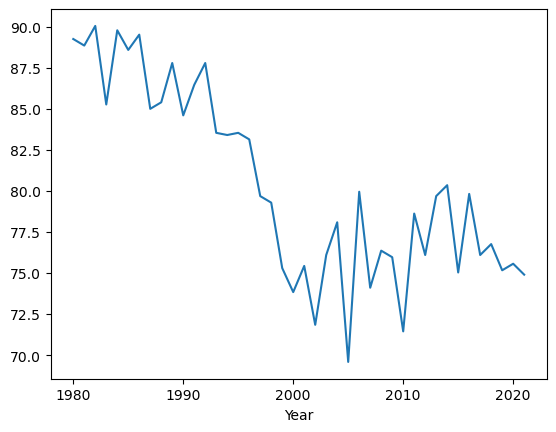

In [4]:
null_count = climate_disaster_df['Frequency'].isnull().groupby(climate_disaster_df['Year']).sum()
total_count = climate_disaster_df['Frequency'].groupby(climate_disaster_df['Year']).count()
climate_disaster_df['Frequency'].fillna(0, inplace=True)
climate_disaster_df['Year']= climate_disaster_df['Year'].astype('int64')
null_proportion = 100 * null_count/(total_count+null_count)

null_proportion.plot.line()

In [5]:
climate_disaster_df.to_csv('Data/Cleaned_Datasets/Climate/climate_disasters.csv', index=False)
climate_disaster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31626 entries, 0 to 31625
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ISO3       31626 non-null  object 
 1   Indicator  31626 non-null  object 
 2   Year       31626 non-null  int64  
 3   Frequency  31626 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 988.4+ KB


# Climate Disaster EDA

<AxesSubplot: xlabel='Year'>

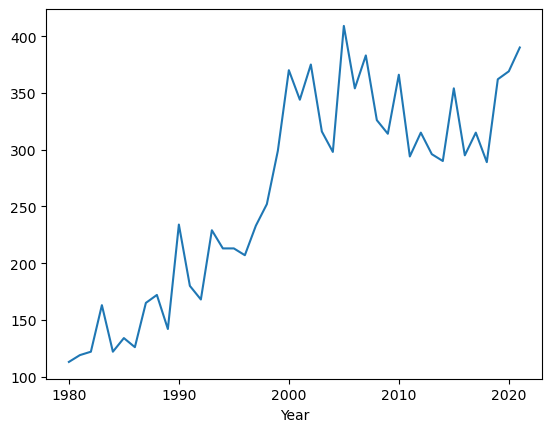

In [6]:
climate_disaster_df.groupby('Year')['Frequency'].sum().plot.line()

Frequency of disasters has been increasing steadily up to the mid 90's. It could be related to more data being gathered around the early 2000's or disasters definition being changed.

<AxesSubplot: xlabel='Year'>

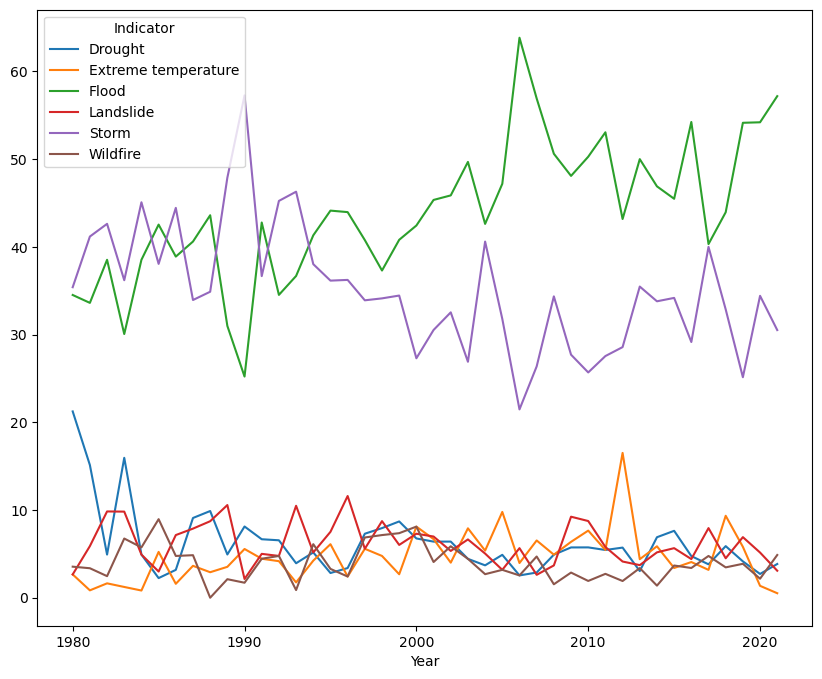

In [7]:
t = climate_disaster_df.groupby(['Year','Indicator'])['Frequency'].sum().to_frame().reset_index().pivot_table(index='Year', columns='Indicator',values='Frequency',aggfunc='sum')

t['Total'] = t.apply(lambda row: row.sum(), axis=1)


df_percentage = t.div(t['Total'], axis=0).mul(100)


df_percentage.drop(columns='Total').plot.line(figsize=(10,8))

The proportion of Flood as the cause of a disaster started around the mid 2000's at the same time when disasters overall increased. 
- Flood seems to be correlated with storms. Will this occur at the same year and same country?
- Landslide, Extreme temperatures and Wildfires seems to have little to no change in the last 40 year

In [8]:
storms_floods = climate_disaster_df[climate_disaster_df['Indicator'].isin(['Flood','Storm'])]
table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year'], columns='Indicator', aggfunc=np.sum).reset_index()

Correlation between the log of storms and flodds: 0.4061611874834078 



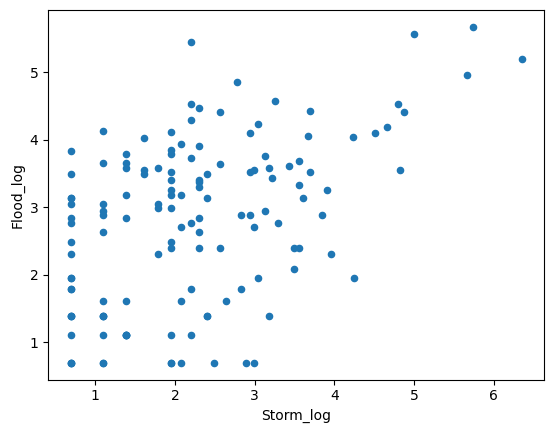

In [9]:
strm_flds_by_country = table_srm_flds.reset_index()[['ISO3','Flood','Storm']].groupby('ISO3').sum().reset_index()
strm_flds_by_year = table_srm_flds.reset_index()[['Year','Flood','Storm']].groupby('Year').sum().reset_index()

strm_flds_by_country['Flood_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Flood']) if x['Flood'] > 0 else 0, axis=1)
strm_flds_by_country['Storm_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Storm']) if x['Storm'] > 0 else 0, axis=1)

strm_flds_by_country[(strm_flds_by_country['Flood_log'] > 0)  & (strm_flds_by_country['Storm_log'] > 0)].plot.scatter(x='Storm_log',y='Flood_log')




r_sq, p = pearsonr(strm_flds_by_country['Storm_log'],strm_flds_by_country['Flood_log'])

print(f'Correlation between the log of storms and flodds: {r_sq} \n')

The correlation between Storms and floods sugest that the observed increased intensity of storms will lead to more flooding in the future. Data paired by country

Correlation between the log of storms and flodds: 0.6568373675221719 



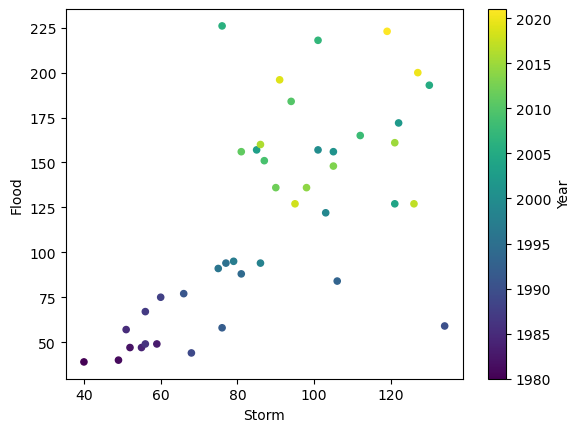

In [10]:
r_sq, p = pearsonr(strm_flds_by_year['Storm'],strm_flds_by_year['Flood'])

strm_flds_by_year.plot.scatter(x='Storm',y='Flood',c='Year',colormap='viridis')
print(f'Correlation between the log of storms and flodds: {r_sq} \n')

When grouped by year, we see the same type of corralation, although stronger. More storms are being registered as the cause of a disaster, and at the same time more floodings are occurring.

In [46]:
country_info = pd.read_csv('Data/Cleaned_Datasets/General/country_information.csv')
climate_disaster_exp = climate_disaster_df.merge(country_info,how='inner',left_on='ISO3',right_on='ISO3')

In [47]:
climate_disaster_exp['Coastline_log'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Coastline'] * x['Area']*100) if x['Coastline'] > 0 else 0,axis=1)
climate_disaster_exp['Area_log'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Area']) ,axis=1)

In [52]:
storms_floods = climate_disaster_exp[['ISO3','Area_log','Coastline_log','Indicator','Frequency','Year','Region']][
            (climate_disaster_exp['Indicator'].isin(['Flood','Storm'])) & (climate_disaster_exp['Year'] >= 1980)
            ]

table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year','Area_log','Coastline_log','Region'], columns='Indicator', aggfunc=np.sum).reset_index()

In [56]:
aggregation = {'Area_log':'mean', 'Coastline_log':'mean','Flood':'sum','Storm':'sum'}

dis_country_area = table_srm_flds.groupby(['ISO3','Region'],as_index=False).agg(aggregation)

<AxesSubplot: xlabel='Area_log', ylabel='Flood'>

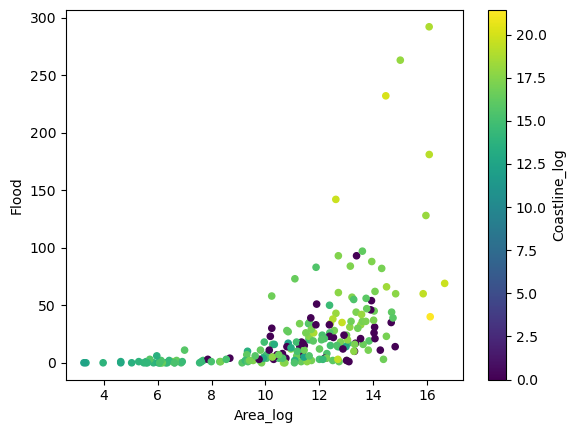

In [54]:
dis_country_area.plot.scatter(x='Area_log', y='Flood',c='Coastline_log',colormap='viridis')

Flooding disasters occurs more often in countries with a larger area, no surprisingly. 
Coastline is not a big predictor of flooding disasters ocurring, because a large proportion occurs in countries with short coastlines and large areas

In [152]:
group_table = dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby(['Region','ISO3']).sum('Flood').reset_index()
lookup = dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby(['Region'])['Flood'].nlargest(1).to_frame().reset_index().drop(columns='level_1').reset_index()

group_table.merge(lookup,how='inner',left_on=['Region','Flood'],right_on=['Region','Flood']).sort_values('Flood',ascending=False)

,Region,ISO3,Area_log,Coastline_log,Flood,Storm,index
0,ASIA (EX. NEAR EAST),AFG,13.380874,0.0,93.0,9.0,0
5,SUB-SAHARAN AFRICA,ETH,13.935182,0.0,54.0,0.0,5
3,LATIN AMER. & CARIB,BOL,13.909529,0.0,46.0,2.0,3
1,C.W. OF IND. STATES,TJK,11.871299,0.0,33.0,2.0,1
6,WESTERN EUROPE,AUT,11.337023,0.0,18.0,19.0,6
2,EASTERN EUROPE,SRB,11.389186,0.0,17.0,0.0,2
4,NEAR EAST,PSE,8.675905,0.0,4.0,3.0,4


In [66]:
dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Flood']>0)].groupby('Region').median('Flood')['Flood'].sort_values(ascending=False)

Region
LATIN AMER. & CARIB                    35.0
ASIA (EX. NEAR EAST)                   23.0
SUB-SAHARAN AFRICA                     22.5
EASTERN EUROPE                         14.0
WESTERN EUROPE                          8.0
C.W. OF IND. STATES                     4.0
NEAR EAST                               4.0
Name: Flood, dtype: float64

Countries with more propensity to flooding without a coastline tend to be countries with usually worse infrastructure. Like Bolivia, Afghanistan  or Ethiopia

<AxesSubplot: xlabel='Coastline_log', ylabel='Storm'>

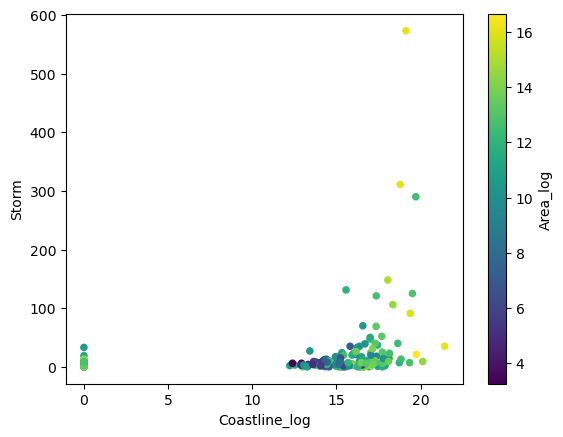

In [35]:
dis_country_area.plot.scatter(x='Coastline_log', y='Storm',c='Area_log',colormap='viridis')

In [153]:
dis_country_area[(dis_country_area['Coastline_log'] == 0) & (dis_country_area['Storm']>0)].sort_values(by='Storm', ascending=False)

Indicator,ISO3,Region,Area_log,Coastline_log,Flood,Storm
31,CHE,WESTERN EUROPE,10.628376,0.0,8.0,33.0
11,AUT,WESTERN EUROPE,11.337023,0.0,18.0,19.0
120,MNG,ASIA (EX. NEAR EAST),14.262831,0.0,11.0,13.0
100,LAO,ASIA (EX. NEAR EAST),12.374971,0.0,23.0,11.0
46,CZE,EASTERN EUROPE,11.275505,0.0,14.0,10.0
29,CAF,SUB-SAHARAN AFRICA,13.342276,0.0,17.0,10.0
0,AFG,ASIA (EX. NEAR EAST),13.380874,0.0,93.0,9.0
108,LUX,WESTERN EUROPE,7.857868,0.0,3.0,9.0
147,PRY,LATIN AMER. & CARIB,12.915954,0.0,24.0,8.0
135,NPL,ASIA (EX. NEAR EAST),11.899418,0.0,51.0,8.0


Storms and Coastiline as expected are related to one another, countries with more coast will have a higher propensity to get storms. <br>
However countries with zero border with the sea will also have disasters related with Storm events. The definition in this dataset is loose and includes windstorms (Switserland ) and Sandstorms (Mongolia) among others

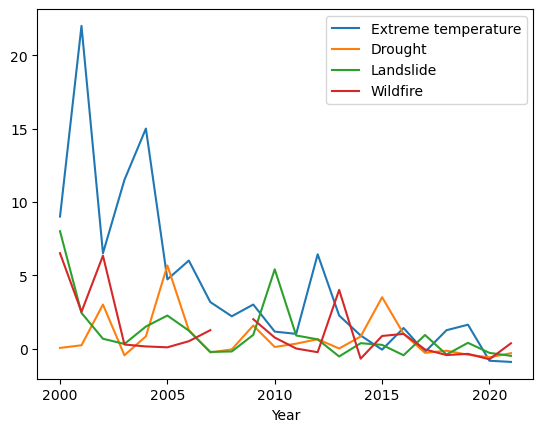

In [178]:
disasters_by_indicator = climate_disaster_df.groupby(['Year','Indicator'])['Frequency'].sum().to_frame().reset_index().pivot_table(index='Year', columns='Indicator',values='Frequency',aggfunc='sum')
num_periods = 20
indicators = ['Extreme temperature','Drought','Landslide','Wildfire']
for indicator in indicators:
    disasters_by_indicator[indicator].pct_change(periods=num_periods).plot.line(legend=True)

The rate of increase of the least significant climate disasters has been decreasing over 20 year periods. 
- There was a significant increase in Extreme temeprature disasters from 1980 to 2000, but the rate of change has stabilized over the last 20 years